## impact function 

Based on the relatiionship of WRSI and crop damagae https://fews.net/fr/east-africa/tanzania/remote-monitoring-report/june-2015


<AxesSubplot:title={'center':'DR 1: Drought on crop damage'}, xlabel='Intensity (WRSI value)', ylabel='Impact (%)'>

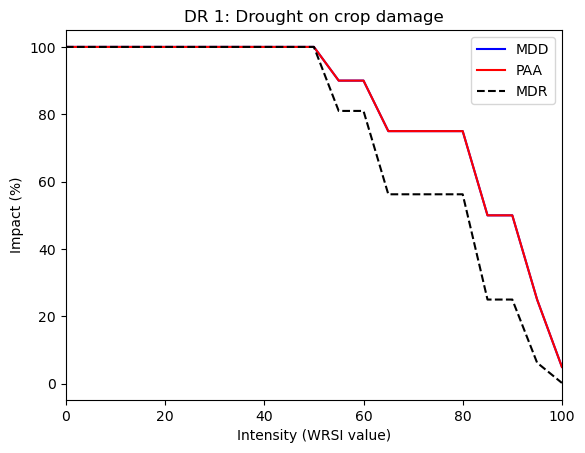

In [2]:
from climada.entity import ImpactFuncSet
from climada.util import ENT_TEMPLATE_XLS
import matplotlib.pyplot as plt

# provide absolute path of the input excel file
#file_name = ENT_TEMPLATE_XLS
file_name=f'data/wrsi/ibf_drought_impact_ea_v0.xlsx'

imp_set_xlsx = ImpactFuncSet.from_excel(file_name)

imp_set_xlsx.plot()

## exposure 

Spatially-Disaggregated Crop Production Statistics Data in Africa South of the Sahara for 2017 https://www.ifpri.org/publication/spatially-disaggregated-crop-production-statistics-data-africa-south-sahara-2017​

Based on Climada documentation 

In [4]:
from climada.entity import Exposures

import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
#from Configuration import *
import os
import pandas as pd

import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#file_path = lp_csv_files[5] # define the full file path of the CSV-file

from more_itertools import sliced
import geopandas as gp
CHUNK_SIZE = 500000

ex_db=pd.read_csv('data/wrsi/ea_agr_spam.csv')

index_slices = sliced(range(len(ex_db)), CHUNK_SIZE)

ea_boundary=gp.read_file('data/wrsi/ea_ghcf_icpac.shp')

edf_cont=[]
for index_slice in index_slices:
    chunk = ex_db.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.longitude, chunk.latitude))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    edf_cont.append(edf)


edf1=pd.concat(edf_cont)
edf2=edf1[['latitude','longitude','value']]
#edf2

#file_path='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_climada/KEN_2021.csv'
#new_exp = Exposures(pd.read_csv(file_path))
#new_exp.check()


/tmp/ipykernel_33971/1698017673.py:31: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  edf=gp.sjoin(ea_boundary,gdb)


In [5]:
ex_db

,value,latitude,longitude,region_id
0,385283.5,23.125000,30.875000,818
1,183732.7,23.125000,30.958333,818
2,183732.7,23.125000,31.041667,818
3,183732.7,23.125000,31.125000,818
4,188736.9,23.125000,32.875000,818
...,...,...,...,...
40802,124831.9,-11.708333,40.125000,508
40803,161620.0,-11.708333,40.208333,508
40804,105369.0,-11.708333,40.291667,508
40805,84965.7,-11.708333,40.375000,508


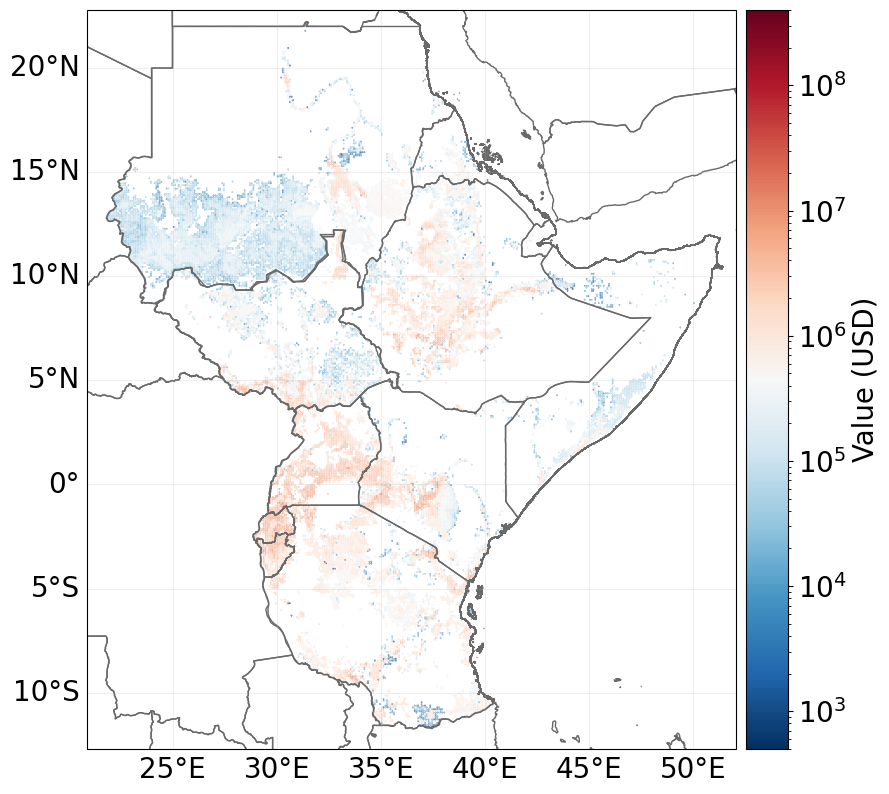

In [6]:
new_exp = Exposures(edf2)
new_exp.check()

norm = colors.LogNorm(vmin=500, vmax=4.0e8)

ax=new_exp.plot_hexbin(norm=norm, pop_name=False, cmap='RdBu_r', buffer=1)

#fname='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_ibf_data_resources/exposure-data/gis/ea_global_background.shp'

#ax.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None')

plt.savefig('data/wrsi/ea_agr_spam_v1.png', bbox_inches='tight')


In [8]:
from climada.entity import Exposures

import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
#from Configuration import *
import os
import pandas as pd

import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#file_path = lp_csv_files[5] # define the full file path of the CSV-file

file_path='data/wrsi/ea_agr_spam.csv'


#file_path='/home/bulbul/Documents/07-2022/impact_weather_icpac/lab/ea_climada/KEN_2021.csv'
new_exp = Exposures(pd.read_csv(file_path))
new_exp.check()

## hazard 

In [9]:
import xarray as xr
import rioxarray 
import pandas as pd

wrsi_mean_path=f'data/wrsi/ens_mean_wrsi_MAM2023_20230211_21.838949_51.415695_-11.745695_23.145147.nc'

db1=xr.open_dataset(wrsi_mean_path)
#db1=db.rename({'longitude':'lon','latitude':'lat'})

times = pd.date_range("2023/02/11","2023/02/11",freq='D',closed='left')

db1['spei'] = db1['__xarray_dataarray_variable__']
db2 = db1.drop(['__xarray_dataarray_variable__'])

#db3=db2.transpose('lat', 'lon')

#db3=db2.spei.cf

db3=db2.transpose( 'latitude', 'longitude')

db3.rio.to_raster(f'data/wrsi/wrsi_20230211.tif',recalc_transform=False)

/tmp/ipykernel_33971/3718082457.py:10: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  times = pd.date_range("2023/02/11","2023/02/11",freq='D',closed='left')


In [10]:
import numpy as np
from climada.hazard import Hazard

haz_ven = Hazard.from_raster([f'data/wrsi/wrsi_20230211.tif'], dst_crs='epsg:4326',attrs={'frequency':np.ones(1)/2}, haz_type='DR')
haz_ven.check()
print('\n Solution 1:')
print('centroids CRS:', haz_ven.centroids.crs)
print('raster info:', haz_ven.centroids.meta)


 Solution 1:
centroids CRS: epsg:4326
raster info: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 119, 'height': 140, 'count': 1, 'crs': 'epsg:4326', 'transform': Affine(0.25, 0.0, 21.75,
       0.0, -0.25, 23.25)}


In [11]:
from climada.engine import Impact

imp_drought = Impact()

"""Calculate Damage for a specific event"""
imp_drought.calc(new_exp, imp_set_xlsx, haz_ven)

2023-06-21 16:22:14,946 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-06-21 16:22:14,954 - climada.hazard.base - WARNING - Impact function id=1 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


In [12]:
index_event_start = imp_drought.event_name.index('1')
damages_drought = np.asarray([imp_drought.at_event[index_event_start]])
print(damages_drought)

[1.79718488e+10]


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

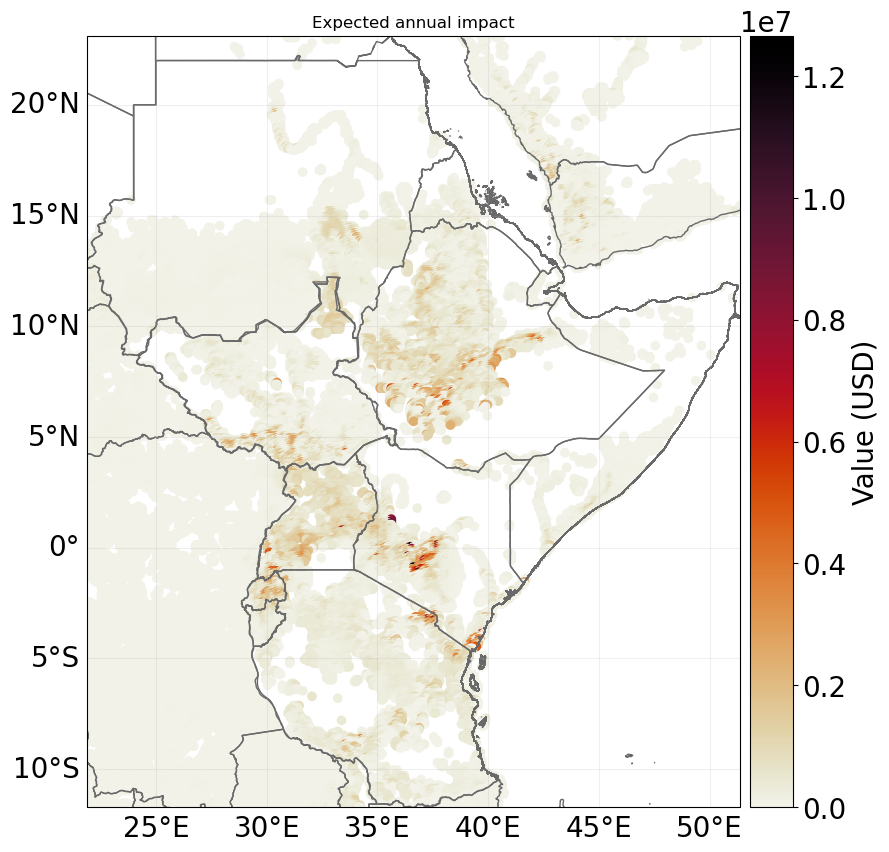

In [13]:
imp_drought.plot_scatter_eai_exposure(pop_name=False)

In [16]:
imp_drought.write_csv('data/wrsi/impact_20230211.csv')

In [19]:
db=pd.read_csv('data/wrsi/impact_20230211.csv')
db1=db[['eai_exp','exp_lat','exp_lon']]
db1.to_csv('data/wrsi/impact_20230211.csv')

/tmp/ipykernel_33971/2065739845.py:1: DtypeWarning: Columns (0,1,2,3,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  db=pd.read_csv('data/impact_20230211.csv')


In [ ]:
from climada.engine import Impact

imp_drought = Impact(pd.read_csv('data/wrsi/impact_20230211.csv'))

#new_imp = imp_drought(pd.read_csv('/home/20230211/impact_20230211.csv'))
imp_drought.check()

## Probablity maps 

In [22]:
import geopandas as gp

db=pd.read_csv('data/wrsi/impact_20230211.csv')
db1=db[['eai_exp','exp_lat','exp_lon']]
db1

g_db1 = gp.GeoDataFrame(db1, geometry=gp.points_from_xy(db1.exp_lon, db1.exp_lat))
g_db1

,eai_exp,exp_lat,exp_lon,geometry
0,0.000000,23.125000,30.875000,POINT (30.87500 23.12500)
1,0.000000,23.125000,30.958333,POINT (30.95833 23.12500)
2,0.000000,23.125000,31.041667,POINT (31.04167 23.12500)
3,0.000000,23.125000,31.125000,POINT (31.12500 23.12500)
4,0.000000,23.125000,32.875000,POINT (32.87500 23.12500)
...,...,...,...,...
40802,27929.408296,-11.708333,40.125000,POINT (40.12500 -11.70833)
40803,36160.236036,-11.708333,40.208333,POINT (40.20833 -11.70833)
40804,29635.031250,-11.708333,40.291667,POINT (40.29167 -11.70833)
40805,23896.603125,-11.708333,40.375000,POINT (40.37500 -11.70833)


In [23]:
dbpath=f'data/wrsi/prob_lower_tercile_MAM2023_20230211_21.838949_51.415695_-11.745695_23.145147.nc'

db1=xr.open_dataset(dbpath)

erf=db1.to_dataframe()

erf1=erf.reset_index()

gdf1 = gp.GeoDataFrame(erf1, geometry=gp.points_from_xy(erf1.longitude, erf1.latitude))

#gdf1=gdf[0:12]

gdf1['polygon']=gdf1.geometry.apply(lambda g: g.buffer(0.125, cap_style=3))

gdf2=gdf1[['__xarray_dataarray_variable__','polygon']]
gdf2.columns=['prob_wrsi','geometry']
#gdf1

In [28]:
gdf3=gdf2.set_geometry("geometry")
gdf3 = gdf3.set_crs('epsg:4326')

g_db2=g_db1.set_geometry("geometry")
g_db3 = g_db2.set_crs('epsg:4326')

In [29]:
wsd=gdf3.sjoin(g_db3)

In [30]:


def get_prob_ibf(row):
    #print(row['prob_wrsi'],row['eai_exp'])
    if 0.0<= row['prob_wrsi'] <=0.25 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    if 0.25<= row['prob_wrsi'] <=0.5 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    if 0.5<= row['prob_wrsi'] <=0.75 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    if 0.75<= row['prob_wrsi'] <=1 and 0.0<= row['eai_exp'] <= 68716.9:
        a=10    
    ########
    if 0.0<= row['prob_wrsi'] <=0.25 and 68716.9<= row['eai_exp'] <= 687169:
        a=10    
    if 0.25<= row['prob_wrsi'] <=0.5 and 68716.9<= row['eai_exp'] <= 687169:
        a=10    
    if 0.5<= row['prob_wrsi'] <=0.75 and 68716.9<= row['eai_exp'] <= 687169:
        a=20    
    if 0.75<= row['prob_wrsi'] <=1 and 68716.9<= row['eai_exp'] <= 687169:
        a=20    
    ########
    if 0.0<= row['prob_wrsi'] <=0.25 and 687169<= row['eai_exp'] <=296190.70:
        a=20    
    if 0.25<= row['prob_wrsi'] <=0.5 and 687169<= row['eai_exp'] <= 296190.70:
        a=20    
    if 0.5<= row['prob_wrsi'] <=0.75 and 687169<= row['eai_exp'] <= 296190.70:
        a=30    
    if 0.75<= row['prob_wrsi'] <=1 and 687169<= row['eai_exp'] <= 296190.70:
        a=30    
    ########
    if 0.0<= row['prob_wrsi'] <=0.25 and 296190.70<= row['eai_exp'] <=29619070:
        a=20    
    if 0.25<= row['prob_wrsi'] <=0.5 and 296190.70<= row['eai_exp'] <= 29619070:
        a=30    
    if 0.5<= row['prob_wrsi'] <=0.75 and 296190.70<= row['eai_exp'] <= 29619070:
        a=30    
    if 0.75<= row['prob_wrsi'] <=1 and 296190.70<= row['eai_exp'] <= 29619070:
        a=40
    ########
    if row['prob_wrsi'] is None and row['eai_exp'] is None: 
        a=np.nan
    if row['prob_wrsi'] is None or row['eai_exp'] is None: 
        a=np.nan 
    if pd.isna(row['prob_wrsi']):
        a=np.nan
    return a

wsd['ibf']=wsd.apply(lambda row: get_prob_ibf(row), axis = 1)
wsd

,prob_wrsi,geometry,index_right,eai_exp,exp_lat,exp_lon,ibf
0,0.754197,"POLYGON ((22.00000 -11.50000, 22.00000 -11.750...",40399,181.1500,-11.541667,21.875000,10.0
0,0.754197,"POLYGON ((22.00000 -11.50000, 22.00000 -11.750...",40400,2862.6750,-11.541667,21.958333,10.0
1,0.694614,"POLYGON ((22.00000 -11.25000, 22.00000 -11.500...",40259,193.3125,-11.458333,21.958333,10.0
1,0.694614,"POLYGON ((22.00000 -11.25000, 22.00000 -11.500...",40133,369.4750,-11.375000,21.875000,10.0
1,0.694614,"POLYGON ((22.00000 -11.25000, 22.00000 -11.500...",40134,1010.0250,-11.375000,21.958333,10.0
...,...,...,...,...,...,...,...
16487,NaN,"POLYGON ((51.25000 15.25000, 51.25000 15.00000...",2548,286262.9000,15.208333,51.125000,NaN
16628,0.578102,"POLYGON ((51.50000 15.50000, 51.50000 15.25000...",2461,3570.6500,15.291667,51.375000,10.0
16628,0.578102,"POLYGON ((51.50000 15.50000, 51.50000 15.25000...",2460,6847.2500,15.291667,51.291667,10.0
16628,0.578102,"POLYGON ((51.50000 15.50000, 51.50000 15.25000...",2372,9436.5000,15.375000,51.375000,10.0


In [31]:
wsd1=wsd[['exp_lat','exp_lon','ibf']]
wsd1.columns=['latitude','longitude','value']

wsd1['region_id']=1

In [32]:
wsd1.to_csv('data/wrsi/probablity_ibf_output.csv',index=False)

## maping of prob_ibf

In [34]:
db=pd.read_csv('data/wrsi/probablity_ibf_output.csv')

from more_itertools import sliced
import geopandas as gp
CHUNK_SIZE = 500000

index_slices = sliced(range(len(db)), CHUNK_SIZE)

ea_boundary=gp.read_file('data/wrsi/ea_ghcf_icpac.shp')

edf_cont=[]
for index_slice in index_slices:
    chunk = db.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.longitude, chunk.latitude))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    edf_cont.append(edf)

/tmp/ipykernel_33971/1176485554.py:15: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  edf=gp.sjoin(ea_boundary,gdb)


In [35]:
edf1=pd.concat(edf_cont)
edf2=edf1[['latitude','longitude','value']]
edf2

,latitude,longitude,value
0,-3.708333,29.291667,10.0
0,-3.375000,29.208333,10.0
0,-3.291667,29.208333,10.0
0,-3.291667,29.291667,10.0
0,-3.208333,29.291667,10.0
...,...,...,...
10,3.125000,34.541667,10.0
10,3.208333,34.208333,20.0
10,2.208333,34.875000,40.0
10,3.625000,34.208333,40.0


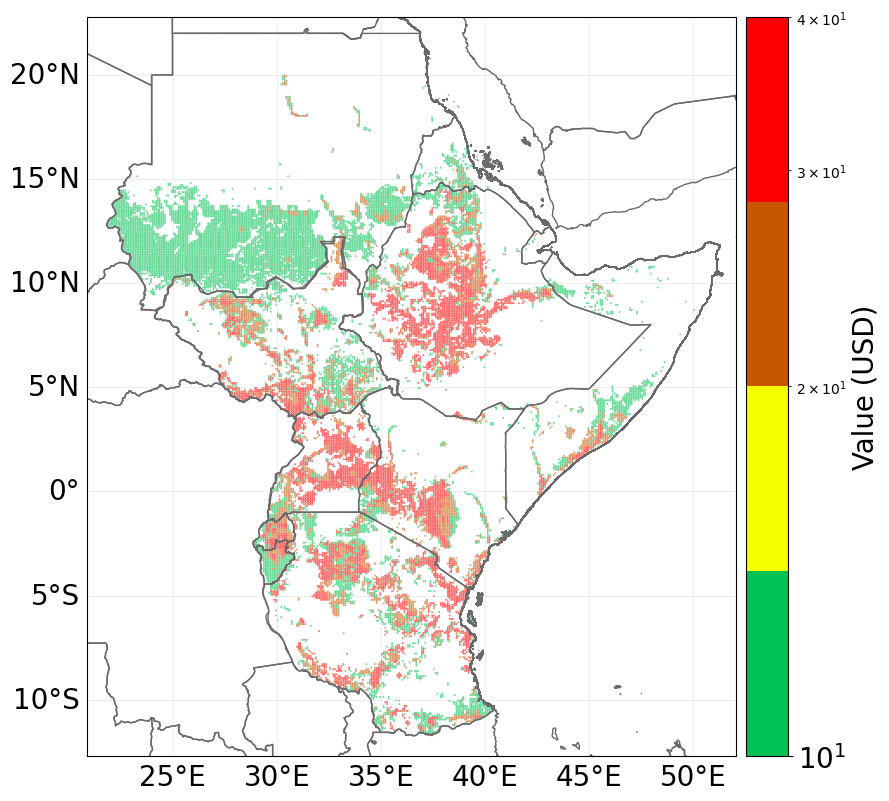

In [36]:
from climada.entity import Exposures
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
from matplotlib import colors
from matplotlib import pyplot as plt
#from Configuration import *
import os
import pandas as pd

import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

#file_path = lp_csv_files[5] # define the full file path of the CSV-file

def return_colormap():
    """
    Create colormap of matplotlib based on number of class and given colorcode

    Parameters
    ----------
    params : class object
        Input/Output parameter definitions.
        
    Returns
    -------
    c_cmap : Object
        matplotlib colormap.

    """
    c = matplotlib.colors.ColorConverter().to_rgb
    colorlist=[c("#00c252"), c("#f3ff00"), c("#c85500"), c("#ff0000")]
    color_code=colorlist
    classif= [10, 20, 30, 40]
    c_cmap = LinearSegmentedColormap.from_list("my_colormap",color_code, N=len(classif), gamma=1.0)
    return c_cmap



new_exp = Exposures(edf2)
new_exp.check()

norm = colors.LogNorm(vmin=10, vmax=40)

c_cmap=return_colormap()

ax=new_exp.plot_hexbin(norm=norm, pop_name=False, cmap=c_cmap, buffer=1)


#ax.add_geometries(Reader(fname).geometries(),ccrs.PlateCarree(),facecolor='None')

#plt.savefig('/home/ibf.png', bbox_inches='tight')


## country wise damage 

In [37]:
import geopandas as gp
import pandas as pd

from more_itertools import sliced

db=pd.read_csv('data/wrsi/impact_20230211.csv')
db1=db[['eai_exp','exp_lat','exp_lon']]


ea_boundary=gp.read_file('data/wrsi/ea_ghcf_icpac.shp')

CHUNK_SIZE = 500000

index_slices = sliced(range(len(db1)), CHUNK_SIZE)

edf_cont=[]
for index_slice in index_slices:
    chunk = db.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.exp_lon, chunk.exp_lat))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    edf_cont.append(edf)

/tmp/ipykernel_33971/3887908603.py:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  edf=gp.sjoin(ea_boundary,gdb)


In [38]:
edf1=pd.concat(edf_cont)
edf1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22247 entries, 0 to 10
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   GID_0        22247 non-null  object  
 1   COUNTRY      22247 non-null  object  
 2   layer        22247 non-null  object  
 3   path         22247 non-null  object  
 4   geometry     22247 non-null  geometry
 5   index_right  22247 non-null  int64   
 6   Unnamed: 0   22247 non-null  int64   
 7   eai_exp      22247 non-null  float64 
 8   exp_lat      22247 non-null  float64 
 9   exp_lon      22247 non-null  float64 
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 1.9+ MB


In [39]:
edf2=edf1[['GID_0', 'COUNTRY', 'eai_exp']]

edf3=edf2.groupby(['GID_0']).sum()

/tmp/ipykernel_33971/3504992437.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  edf3=edf2.groupby(['GID_0']).sum()


In [40]:
edf4=edf3.reset_index()

In [41]:
exdb=pd.read_csv('data/wrsi/ea_agr_spam.csv')

CHUNK_SIZE = 500000

index_slices = sliced(range(len(exdb)), CHUNK_SIZE)

ex_edf_cont=[]
for index_slice in index_slices:
    chunk = exdb.iloc[index_slice]
    gdb = gp.GeoDataFrame(chunk, geometry=gp.points_from_xy(chunk.longitude, chunk.latitude))
    edf=gp.sjoin(ea_boundary,gdb)
    #edf1=edf[['GID_0', 'COUNTRY','gno','Nomotorway','primary','secondary','tertiary','unclassified','lon','lat', 'grid_name']]
    ex_edf_cont.append(edf)

/tmp/ipykernel_33971/221790804.py:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  edf=gp.sjoin(ea_boundary,gdb)


In [42]:
ex_edf1=pd.concat(ex_edf_cont)
ex_edf2=ex_edf1[['GID_0', 'COUNTRY', 'value']]

ex_edf3=ex_edf2.groupby(['GID_0']).sum()

/tmp/ipykernel_33971/3113810.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ex_edf3=ex_edf2.groupby(['GID_0']).sum()


In [43]:
ex_edf4=ex_edf3.reset_index()
ex_edf4

,GID_0,value
0,BDI,9.385453e+08
1,DJI,4.888634e+06
2,ERI,9.804281e+07
3,ETH,4.915424e+09
4,KEN,3.278714e+09
5,RWA,1.329327e+09
6,SDN,1.575073e+09
7,SOM,2.089309e+08
8,SSD,2.260229e+09
9,TZA,4.758201e+09


In [44]:
er=pd.merge(ex_edf4,edf4,on='GID_0')

def percentage_change(col1,col2):
    return ((col2 - col1) / col1) * 100

er['per_loss'] =  percentage_change(er['value'],er['eai_exp'])
er

,GID_0,value,eai_exp,per_loss
0,BDI,9.385453e+08,1.011739e+08,-89.220140
1,DJI,4.888634e+06,1.167843e+06,-76.111054
2,ERI,9.804281e+07,4.886777e+07,-50.156706
3,ETH,4.915424e+09,2.307393e+09,-53.058107
4,KEN,3.278714e+09,1.288785e+09,-60.692360
5,RWA,1.329327e+09,2.502813e+08,-81.172321
6,SDN,1.575073e+09,6.625213e+08,-57.937108
7,SOM,2.089309e+08,1.037909e+08,-50.322842
8,SSD,2.260229e+09,1.003386e+09,-55.606908
9,TZA,4.758201e+09,1.339611e+09,-71.846275


In [45]:
er.style.format(precision=2)

er['Crop Production value in US$'] = '$' + (er['value'].astype(float)/1000000).round(2).astype(str) + 'MM'
er['Crop Production value after impact factor in US$'] = '$' + (er['eai_exp'].astype(float)/1000000).round(2).astype(str) + 'MM'
er1=er[['GID_0','Crop Production value in US$','Crop Production value after impact factor in US$','per_loss']]

er1['Country']=['Burundi',
 'Djibouti',
 'Eritrea',
 'Ethiopia',
 'Kenya',
 'Rwanda',
 'Sudan',
 'Somalia',
 'South Sudan',
 'Tanzania',
 'Uganda']

er2=er1[['Country','Crop Production value in US$','Crop Production value after impact factor in US$','per_loss']]
er2

,Country,Crop Production value in US$,Crop Production value after impact factor in US$,per_loss
0,Burundi,$938.55MM,$101.17MM,-89.220140
1,Djibouti,$4.89MM,$1.17MM,-76.111054
2,Eritrea,$98.04MM,$48.87MM,-50.156706
3,Ethiopia,$4915.42MM,$2307.39MM,-53.058107
4,Kenya,$3278.71MM,$1288.79MM,-60.692360
5,Rwanda,$1329.33MM,$250.28MM,-81.172321
6,Sudan,$1575.07MM,$662.52MM,-57.937108
7,Somalia,$208.93MM,$103.79MM,-50.322842
8,South Sudan,$2260.23MM,$1003.39MM,-55.606908
9,Tanzania,$4758.2MM,$1339.61MM,-71.846275


In [53]:
er1

,GID_0,Crop Production value in US$,Crop Production value after impact factor in US$,per_loss,Country
0,BDI,$938.55MM,$101.17MM,-89.220140,Burundi
1,DJI,$4.89MM,$1.17MM,-76.111054,Djibouti
2,ERI,$98.04MM,$48.87MM,-50.156706,Eritrea
3,ETH,$4915.42MM,$2307.39MM,-53.058107,Ethiopia
4,KEN,$3278.71MM,$1288.79MM,-60.692360,Kenya
5,RWA,$1329.33MM,$250.28MM,-81.172321,Rwanda
6,SDN,$1575.07MM,$662.52MM,-57.937108,Somalia
7,SOM,$208.93MM,$103.79MM,-50.322842,South Sudan
8,SSD,$2260.23MM,$1003.39MM,-55.606908,Sudan
9,TZA,$4758.2MM,$1339.61MM,-71.846275,Tanzania


In [49]:
ex_edf3=ex_edf2.groupby(['COUNTRY']).sum()
ex_edf4=ex_edf3.reset_index()
ex_edf4['COUNTRY'].tolist()

/tmp/ipykernel_48/3284114877.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ex_edf3=ex_edf2.groupby(['COUNTRY']).sum()


['Burundi',
 'Djibouti',
 'Eritrea',
 'Ethiopia',
 'Kenya',
 'Rwanda',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Tanzania',
 'Uganda']